## Notebook  : Compute correlation and kinetic energy spectra using drifters data

### Description : 
In this notebook we compute correlation function and kinetic energy spectra using the drifters trajectories from our simulations output.
A decomposition of the time series in overlapping time windows is done. The total time period used, T is decomposed in time windows (segments) overlapping by usually 50%. The correlation or spectrum computation is done on each segment.

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima


import crocosi.postp as pp
from crocosi.jet import set_relevant_time

import phdequinox.croco_drifter as cdr

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=6)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [5]:
client

Client Scheduler: tcp://10.148.0.219:54515 Dashboard: http://10.148.0.219:8787/status,Cluster Workers: 7 Cores: 7 Memory: 119.98 GB


---

## load data

In [6]:
#root_path = '/home/datawork-lops-osi/slgentil/croco/jetn/'
root_path = '/home/datawork-lops-osi/equinox/jetn/old/'

run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'
#run = 'jet_cfg1_wp6_m2_4km_500a1000j/'
L=1026 # corresponds to the x period 

In [7]:
dr = cdr.drifter_dataframe(root_path+run,parquet=True,index='id',persist=False)
dr

         time      xgrid      ygrid  zgrid     depth       temp         u  \
id                                                                          
1   1514.4167  25.897255  174.72748   50.0  0.870458  24.579730 -0.000864   
1   1508.3056  26.356433  168.51951   50.0  0.763907  24.579722  0.059964   
1   1508.2986  26.348080  168.48829   50.0  0.764288  24.579721  0.054308   
1   1508.2917  26.340585  168.45690   50.0  0.764393  24.579721  0.048543   
1   1508.2847  26.333961  168.42548   50.0  0.764202  24.579721  0.042720   

           v      dudt          dvdt      pres           x          y  
id                                                                     
1   0.089855  0.000009 -9.453702e-06  9.414380  103.589020  698.90992  
1   0.203875  0.000010 -4.799399e-06  8.369084  105.425732  674.07804  
1   0.207708  0.000010 -3.143696e-06  8.372827  105.392320  673.95316  
1   0.209148  0.000010 -1.401524e-06  8.373855  105.362340  673.82760  
1   0.209600  0.000010  3.03

### load one drifter time series for tests

In [7]:
df = dr.df.loc[225].compute()
#df.head()


In [10]:
df

,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
id,,,,,,,,,,,,,
225,1514.3403,242.688680,486.06541,50.0,-0.454435,25.723625,0.028135,0.093140,0.000009,-0.000017,-3.542983,970.754720,1944.26164
225,1514.3333,242.686650,486.04844,50.0,-0.453796,25.723537,0.022532,0.102637,0.000011,-0.000015,-3.536709,970.746600,1944.19376
225,1542.4653,6.452626,510.06574,50.0,-0.242363,25.697382,0.286140,0.073568,0.000007,-0.000007,-1.463202,25.810502,2040.26296
225,1560.1319,37.056699,484.97537,50.0,-0.572257,25.723402,0.218889,0.377868,0.000022,-0.000032,-4.698570,148.226796,1939.90148
225,1542.9236,8.670853,509.47021,50.0,-0.227784,25.696447,0.188402,0.103828,0.000013,-0.000002,-1.320217,34.683412,2037.88084
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,1918.2778,203.607290,522.10054,50.0,-0.526051,25.965172,-0.056717,0.048494,-0.000002,-0.000016,-4.236348,814.429160,2088.40216
225,1606.8750,181.237830,358.24147,50.0,-0.909428,25.690456,0.839395,0.470139,-0.000002,-0.000041,-8.007649,724.951320,1432.96588
225,1946.8542,169.378190,515.52958,50.0,-0.770359,25.961328,0.125162,-0.243898,-0.000010,-0.000025,-6.633190,677.512760,2062.11832


10.000004444753099

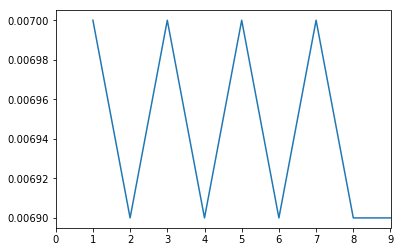

In [12]:
# illustrates variations in drifter time steps
df.sort_values('time').reset_index()['time'].diff().iloc[:10].plot()
df.sort_values('time').reset_index()['time'].diff().mean(axis=0)*24*60

---

## compute lagged autocorrelations

In [8]:
# inputs: time window and step
T = 20 # days
dt = 10./60./24. # days, hack required because dt fluctuates by a bit !!
binsize = 50

In [9]:
# apply to one drifter
out = cdr.time_window_processing(df,cdr.correlate, ['u','u'], T, int(T/dt/2),L,detrend=True,dt=dt)
out

,x,y,id,0.0,0.006944444444444444,0.013888888888888888,0.020833333333333332,0.027777777777777776,0.034722222222222224,0.041666666666666664,...,9.944444444444445,9.951388888888888,9.958333333333332,9.965277777777777,9.972222222222221,9.979166666666666,9.98611111111111,9.993055555555555,trend_var_0,trend_var_1
1510.0069,1022.866620,1942.883560,225.0,0.030004,0.029948,0.029829,0.029648,0.029405,0.029103,0.028743,...,-0.003793,-0.003799,-0.003804,-0.003809,-0.003814,-0.003818,-0.003821,-0.003824,0.007652,0.007652
1520.0069,945.092028,1953.198851,225.0,0.025374,0.025275,0.024982,0.024496,0.023822,0.022964,0.021930,...,-0.008873,-0.009269,-0.009592,-0.009839,-0.010010,-0.010101,-0.010114,-0.010048,0.003712,0.003712
1530.0069,930.432523,1974.050691,225.0,0.031653,0.031507,0.031145,0.030570,0.029788,0.028804,0.027627,...,-0.001516,-0.001280,-0.001044,-0.000807,-0.000573,-0.000343,-0.000119,0.000098,0.007167,0.007167
1540.0069,1012.620378,1995.372894,225.0,0.035732,0.035628,0.035328,0.034835,0.034154,0.033292,0.032254,...,-0.002012,-0.002164,-0.002326,-0.002497,-0.002676,-0.002862,-0.003053,-0.003249,0.016541,0.016541
1550.0069,96.897904,1952.648187,225.0,0.029837,0.029695,0.029338,0.028768,0.027992,0.027017,0.025854,...,0.003781,0.003669,0.003522,0.003339,0.003123,0.002875,0.002596,0.002287,0.013409,0.013409
1560.0069,157.918396,1953.855647,225.0,0.022541,0.022453,0.022200,0.021785,0.021213,0.020488,0.019617,...,0.002493,0.002110,0.001710,0.001296,0.000872,0.000439,0.000001,-0.000439,0.007957,0.007957
1570.0069,239.144614,1976.728432,225.0,0.045940,0.045773,0.045330,0.044615,0.043635,0.042400,0.040920,...,-0.006124,-0.005849,-0.005575,-0.005303,-0.005035,-0.004771,-0.004514,-0.004264,0.008472,0.008472
1580.0069,288.544081,1884.823073,225.0,0.055374,0.055164,0.054618,0.053743,0.052546,0.051039,0.049235,...,0.006610,0.006103,0.005483,0.004754,0.003924,0.002998,0.001984,0.000892,0.001656,0.001656
1590.0069,349.592708,1808.957312,225.0,0.032028,0.031893,0.031513,0.030891,0.030035,0.028954,0.027658,...,0.004303,0.004505,0.004673,0.004806,0.004902,0.004960,0.004978,0.004958,0.048929,0.048929
1600.0069,548.147290,1662.938952,225.0,0.091907,0.091643,0.090951,0.089837,0.088312,0.086394,0.084101,...,0.013793,0.014021,0.014202,0.014336,0.014421,0.014458,0.014447,0.014387,0.092783,0.092783


### map the computation for each drifter

Here we compute the autocorrelation function of the zonal velocity and then compute the average value by binning the result in the y axis. This gives an average by y bins of the autocorrelation of u depending on the lag.

In [15]:
def wrap_correlate(columns,T,dt,L,binsize,detrend=True):
#df_chunked = dr.df.groupby(['id']).apply(chunk_processing, 10., .5)
    df_chunked = dr.df.groupby(dr.df.index).apply(cdr.time_window_processing,
                                                  cdr.correlate, columns, T, int(T/dt/2),L, detrend=True,dt=dt
                                                 ).persist()
                                         #   meta=('x', 'f8'))
    # the dataframe partitions has a multi-index: id and window central time (unknow name for now)
    # we first transform the index corresponding to time into a regular column.
    df_chunked = (
                  df_chunked.map_partitions(
                      lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                           )
                  )
    # bin along y and sum
    y_bins = np.arange(0,2800,binsize)
    y_idx = pd.IntervalIndex.from_breaks(y_bins)
    df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
    return df_chunked

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
df_chunked = wrap_correlate(['u','v'],T,dt,L,binsize,detrend=True)

In [18]:
uv = df_chunked.groupby(['y_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
ds = (pd.melt(uv.set_index(uv.index.map(lambda v: v.mid))
              .drop(columns=['id','time','x','y'])
              .reset_index(), id_vars=['y_cut','trend_var_0','trend_var_1'], var_name='lag')
              .rename(columns={'y_cut': 'y_bins', 'value': 'uv'})).to_xarray().set_index(index=['y_bins','lag']).unstack()

In [ ]:
df_chunked = wrap_correlate(['u','u'],T,dt,L,binsize,detrend=True)

In [ ]:
uu = df_chunked.groupby(['y_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
ds['uu'] = (pd.melt(uu.set_index(uu.index.map(lambda v: v.mid))
                    .drop(columns=['id','time','x','y'])
                    .reset_index(), id_vars=['y_cut','trend_var_0','trend_var_1'], var_name='lag')
                    .rename(columns={'y_cut': 'y_bins', 'value': 'uu'}))
                    .to_xarray().set_index(index=['y_bins','lag']).unstack().uu

In [ ]:
df_chunked = wrap_correlate(['v','v'],T,dt,L,binsize,detrend=True)

In [ ]:
vv = df_chunked.groupby(['y_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
ds['vv'] = (pd.melt(vv.set_index(vv.index.map(lambda v: v.mid))
                    .drop(columns=['id','time','x','y'])
                    .reset_index(), id_vars=['y_cut','trend_var_0','trend_var_1'], var_name='lag')
                    .rename(columns={'y_cut': 'y_bins', 'value': 'vv'}))
                    .to_xarray().set_index(index=['y_bins','lag']).unstack().vv

In [ ]:
df_chunked = wrap_correlate(['v','u'],T,dt,L,binsize,detrend=True)

In [ ]:
vu = df_chunked.groupby(['y_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
ds['vu'] = (pd.melt(vu.set_index(vu.index.map(lambda v: v.mid))
                    .drop(columns=['id','time','x','y'])
                    .reset_index(), id_vars=['y_cut','trend_var_0','trend_var_1'], var_name='lag')
                    .rename(columns={'y_cut': 'y_bins', 'value': 'vu'}))
                    .to_xarray().set_index(index=['y_bins','lag']).unstack().vu

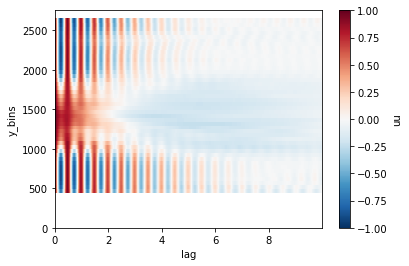

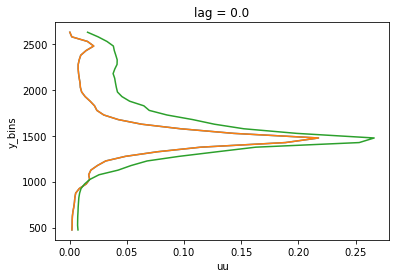

In [24]:
#Normalized autocorrelation 
(ds['uu']/ds['uu'].sel(lag=0.)).plot()
plt.figure()
ds['trend_var_0'].sel(lag=0).plot(y='y_bins')
ds['trend_var_1'].sel(lag=0).plot(y='y_bins')
ds['uu'].sel(lag=0).plot(y='y_bins',label='Variance u')

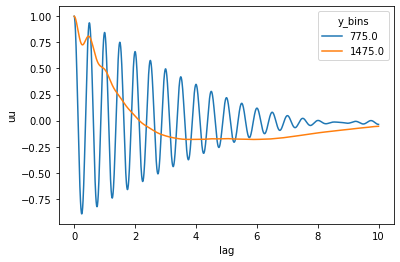

In [26]:
(ds['uu']/ds['uu'].sel(lag=0.)).isel(y_bins=[15,29]).plot.line(x='lag')

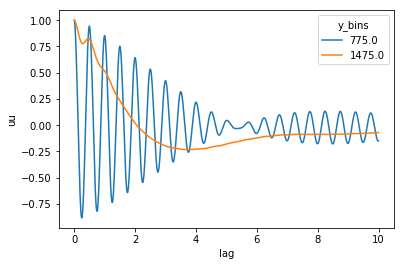

In [50]:
#Autocorrelation at 2 different y : 
#(ds['uu']/ds['uu'].sel(lag=0.)).sel(y_bins=600, method='nearest').plot.line(x='lag')
(ds['uu']/ds['uu'].sel(lag=0.)).isel(y_bins=[15,29]).plot.line(x='lag')

In [27]:
ds.attrs = {'Window' : T, 'Overlap' : 0.5, 'Bins_size' : binsize, 'Fourier window' : 'hann', 'detrend':'linear'}

In [29]:
#Save data in nc file
name = 'Lcorr_'+str(T)
ds.to_netcdf(path = '/home1/datawork/zcaspar/diags/'+name)

---
## compute spectra

In [9]:
from scipy import signal

def get_spectrum(v, N, dt=None, method='welch', detrend='linear', **kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v: ndarray, pd.Series
            Time series, the index must be time if dt is not provided
            
        N: int
            Length of the output
            
        dt: float, optional
            Time step
        
        method: string
            Method that will be employed for spectral calculations.
            Default is 'welch'
            
        detrend: boolean, optional
            Turns detrending on or off. Default is 'linear'.

    See: 
        - https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.periodogram.html
        - https://krischer.github.io/mtspec/
        - http://nipy.org/nitime/examples/multi_taper_spectral_estimation.html
    '''
    if v is None:
        _v = np.random.randn(N)
    else:
        _v = v.iloc[:N]
    if dt is None:
        dt = _v.reset_index()['index'].diff().mean()
    if detrend and not method=='welch':
        print('!!! Not implemented yet except for welch')    
    if method=='welch':
        dkwargs = {'window': 'hann', 'return_onesided': False, 
                   'detrend': 'linear', 'scaling': 'density'}
        dkwargs.update(kwargs)
        f, E = signal.periodogram(_v, fs=1/dt, axis=0, **dkwargs)
    elif method=='mtspec':
        lE, f = mtspec(data=_v, delta=dt, time_bandwidth=4.,
                       number_of_tapers=6, quadratic=True)
    elif method=='mt':
        dkwargs = {'NW': 2, 'sides': 'twosided', 
                   'adaptive': False, 'jackknife': False}
        dkwargs.update(kwargs)
        lf, E, nu = tsa.multi_taper_psd(_v, Fs=1/dt, **dkwargs)
        f = fftfreq(len(lf))*24.
        #print('Number of tapers = %d' %(nu[0]/2))
    return pd.Series(E, index=f)

In [10]:
dr.df['ui'] = dr.df.u+1j*dr.df.v

In [ ]:
# run computation over the whole dateset
T=20
dt = 10./60./24
df_chunked = apply_twin_processing(dr, get_spectrum, ['ui'], T, int(T/dt/2), dt=dt)

# bin sum
y_bins = np.arange(0,2800,30)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
Eu = df_chunked.groupby(['y_cut']).mean().compute()

ds_ft = (pd.melt(Eu.set_index(Eu.index.map(lambda v: v.mid))
              .drop(columns=['time','x','y'])
              .reset_index()
            , id_vars=['y_cut'], var_name='frequency')
      .rename(columns={'y_cut': 'y_bins', 'value': 'Eu'})
      .set_index(['y_bins','frequency'])
      .to_xarray()
     )



/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.


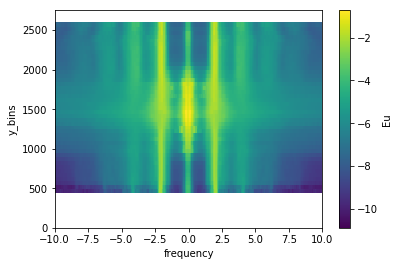

In [36]:
np.log10(ds.Eu).plot(x='frequency',y='y_bins',xlim=(-10,10))

Text(0,0.5,'Power spectral density')

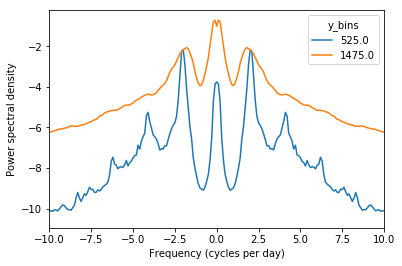

In [24]:
#Plot KE spectra for 2 y : 

np.log10(ds_ft.Eu.isel(y_bins=[10,29])).plot.line(x='frequency', xlim=(-10,10))
plt.xlabel('Frequency (cycles per day)');plt.ylabel('Power spectral density')

In [ ]:
#Save data in nc file
#name = 'Lspectra_'+str(T)+'.nc'
#ds_ft.to_netcdf(path = '/home1/datawork/zcaspar/diags/'+name)

---

In [6]:
cluster.close()